<a href="https://colab.research.google.com/github/SiyiDai/pphau_lab/blob/daisy_branch/PPHAU_Object_detection_using_YOLO_and_Mask_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 3 PPHAU-Object detection using YOLO and instance segmentation using Mask R-CNN

This tutorial will introduce you to how to use YOLO and Mask RCNN for object detection and instance segmentation. 

## 1-1 What are object detection and instance segmentation

### 1-1-1 Image classification
The basic task of a convolutional neural network is image classification, where the network takes an image as input and returns a list of values representing the probability that the image belongs to one of several categories. You can find it in the first picture below.


### 1-1-2 Image classification with localization
The goal for imagesclassification with localization is that we aim to get the predicted image class label as well as the bounding box of object in the image. You can find it in the second picture below.


### 1-1-3 Object detection - YOLO
Object detection is not focusing on the single image class label but aims to find the class of objects contained in an image and the corresponding bounding box. You can find it in the third picture below.


### 1-1-4 Instance segmentation - Mask R-CNN
Instance segmentation aims to detect and localize objects in pixel level. After predicting the semantic information for every pixel, the segmentation mask can be used for localizing objects in detail. You can find it in the last picture below.




<figure style="text-alin:center">
<img src="assets/object detection.png" />
<figcaption >  </figcaption>
</figure>


Source: Arthur Ouaknine, Review of Deep Learning Algorithms for Object Detection, 2018

## 1-2 YOLO --- You Only Look Once

### 1-2-1 What is **YOLO**?

**YOLO** is a obeject detection model, which is commonly used for real-time object detection. 

**YOLO** was proposed by Redmon et al., in 2016 and published in the top computer vision conference CVPR (Computer Vision and Pattern Recognition) https://arxiv.org/abs/1506.02640

The full name of **YOLO** is you only look once, which means that you only need to navigate once to identify the class and location of the objects in the picture.

### Overview structire of YOLO
- Image as input
- Grid the image
- Predict bounding box and class label

<figure style="text-alin:center">
<img src="assets/over_view_structure.PNG" width="800" height="600" />
<figcaption >  </figcaption>
</figure>


The **outputs** of YOLO:
- Center of a bounding box (x, y)
- Width of the bounding box (w)
- Height of the bounding box (h)
- The confidence score - how likely the box contains an object
- The probability of the corresponding class of an object

### 1-2-2 Why YOLO is called You Only Look Once?

Because the Region-free method like YOLO requires only one scan, it is also known as a single-stage (1-stage) model. the Region-based method approach is also known as a two-stage (2-stage) approach.

Because you only need to look once, YOLO is called **Region-free** method. Compared with **Region-based** (Mask R-CNN) method, YOLO does not need to find the Region where the target may exist in advance.

That is, the process of a typical Region-base method is like this: first, the image is analyzed by a region proposal network to find several regions where objects may exist, and these regions are cropped down and put into an image classifier, which classifies them.

- Region-free and Region-based

<figure style="text-alin:center">
<img src="assets/2_stages.PNG" width="800" height="600" />
<figcaption >  </figcaption>
</figure>


### 1-2-3  High level overview of YOLOv3 principle
Before we do that, let's reiterate our task. Our goal is to find an object in a picture and give its category and location. Object detection is based on supervised learning, and the supervised information for each image is the N objects it contains, and there are five pieces of information for each object, namely the object's **center position** (x,y) and its **height** (h) and **width** (w), **confidence score** (c) and finally its **class**.

YOLO's prediction is based on the whole image, and it outputs all the detected object information, including class and location, at once.



#### 1-2-3-1 Grid the image

Let's assume that the image we are working with is a square.


The **first step** of YOLO is to split the image, it splits the image into $n*n$ grids, each of which is of equal size.

<figure style="text-alin:center">
<img src="assets/grids.PNG" width="320" height="320" />
<figcaption >  </figcaption>
</figure>

The smart thing about YOLO is that it only requires the center of this object to fall within this box.

This means that we don't have to design large boxes, because we only need to have the center of the object in this box, rather than having to have the whole object in this box.


#### 1-2-3-2 Bounding Box 

We want each of the $n*n$ grids to predict B bounding boxes. The bounding boxes have five quantities, which are the object's center position (x,y) and its height (h) and width (w), confidence score (c) as well as the class probability of this prediction.

<figure style="text-alin:center">
<img src="assets/bounding_box.PNG" width="800" height="320" />
<figcaption >  </figcaption>
</figure>


That is, if we have $n*n$ grids, the number of bounding boxes for each box is B, and the classifier can recognize C different objects, then the length of all the whole preiction is: 
- $n*n*(B*5+C)$ 

You can see that some of these bounding boxes have **thicker** borders and some are **thinner**, which is a sign of different probability, with those with high confidence score being thicker and those with low confidence score being thinner.

#### 1-2-3-3 Non Maximal Suppression

In Non Maximal Suppression, YOLO removes all bounding boxes that have **lower confidence scores** and remains the bounding boxes that have **high confidence scores**. Afterward, it remove the bounding boxes having the **Intersection over Union(IOU)** less than a threshold with the current high probability bounding box.



#### 1-2-3-4 Intersection over Union
$IoU$: The full name of this $IoU$ is intersection over union, which means intersection-parallel ratio, and it reflects the similarity of bounding boxes.

<figure style="text-alin:center">
<img src="assets/iou.PNG" width="600" height="400" />
<figcaption >  </figcaption>
</figure>

***An example of multiple bounding boxes for one object***

This seems to allow each grid to find the responsible object and identify it. But there is also a problem that has to be considered, what if the object has been detected by multiple bounding boxes?

<figure style="text-alin:center">
<img src="assets/multi_bboxes.PNG" width="800" height="600" />
<figcaption >  </figcaption>
</figure>

For example, in the above diagram of the dog, $B1(b)$, $B2(y)$, $B3(g)$, $B4(r)$, the four boxes may say that the dog is in our bounding box, but the final output should be only one bounding box, then how to remove the other boxes?

Here we use the confidence scores we talked about before. Confidence score indicates how sure **this kind of object** is in our box, so we choose the box with the higher confidence score (more than 0.6), that is, $B1 (0.9)$, $B2 (0.8)$, $B3 (0.7)$. And then also remove the other bounding boxes which have high IoU (e.g., 0.6) with the bounding box has highest confidence score.

And in case, their IoU are all bigger than a threshold (0.6), we only $B1$ with highest confidence score. After this, we continue doing the same processing for the next object (e.g., bike).

Finally, we combine the kinds of bounding box and classification to determine what objects are in the picture, what they are, and where they are, respectively.


<figure style="text-alin:center">
<img src="assets/final_detection.PNG" width="320" height="320"/>
<figcaption >  </figcaption>
</figure>

## Please downloade the assets from this link:

- https://syncandshare.lrz.de/getlink/fiRD5DLLxUCkxFR1Z8GHB3Tr/assets.zip
- Password: pphau2022

# 1-2 Now, let us start to make YOLO-v3 work.
- Opencv is used to build YOLO-v3 object detection pipeline.
- You can also find the pretrained weights and config files in the **assets** folder.

In [ ]:
# download yolo-v3 weights
!wget https://pjreddie.com/media/files/yolov3.weights

--2022-03-07 15:38:03--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236,52M  4,90MB/s    in 80s     

2022-03-07 15:39:25 (2,96 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [ ]:
# download yolo-v3 config file
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg

--2022-03-07 17:58:18--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8,1K) [text/plain]
Saving to: ‘yolov3.cfg’

yolov3.cfg          100%[===================>]   8,15K  --.-KB/s    in 0s      

2022-03-07 17:58:18 (86,3 MB/s) - ‘yolov3.cfg’ saved [8342/8342]



In [ ]:
# For the  coco.name, you can find it in the 'asset' folder
# !wget https://raw.githubusercontent.com/pjreddie/darknet/blob/master/data/coco.names

--2022-03-07 18:05:06--  https://raw.githubusercontent.com/pjreddie/darknet/blob/master/data/coco.names
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2022-03-07 18:05:06 ERROR 404: Not Found.



In [ ]:
# download pre-trained weights for custom model training
!wget https://pjreddie.com/media/files/darknet53.conv.74

--2022-03-08 15:02:01--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154,96M   219KB/s    in 9m 28s  

2022-03-08 15:11:30 (279 KB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



In [ ]:
# Creat a virtual environment

!python3 -m venv env
!source ./env/bin/activate 

In [ ]:
# install opencv-python
!pip install -q opencv-python==4.5.5.64 numpy matplotlib

You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.


## 1-2-1 Object detection using YOLO-v3

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
# set classes file
classesFile = 'assets/yolov3/coco.names'
with open(classesFile,'rt') as f:
    className = f.read().rstrip('\n').split('\n')

# set model configuration
modelConfiguration = 'assets/yolov3/yolov3.cfg'

# set model weights
modelWeights = 'assets/yolov3/yolov3.weights'

# set YOLO-v3 network
net = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

In [ ]:
# function for find objects and draw bounding boxes
def find_objects(outputs, img):
    hT, wT, cT = img.shape
    bbox, confs, classIDs = [], [], []

    for output in outputs:
        for detection in output:
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            if confidence > conf_threshold:
                w, h = int(detection[2]*wT), int(detection[3]*wT)
                x, y = int(detection[0]*wT - w/2), int(detection[1]*hT - h/2)
                bbox.append([x, y, w, h])
                classIDs.append(classID)
                confs.append(float(confidence))
                # print(classIDs)

    # print(len(bbox))
    indices = cv2.dnn.NMSBoxes(bbox, confs, conf_threshold, nms_threshold)
    
    for object_i in indices:
        # print(object_i, 'object')
        # i = object_i[0]
        i = object_i
        box = bbox[i]
        x, y, w, h = box[0], box[1], box[2], box[3]
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(img, f'{className[classIDs[i]].upper()}{int(confs[i]*100)}%',
                   (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

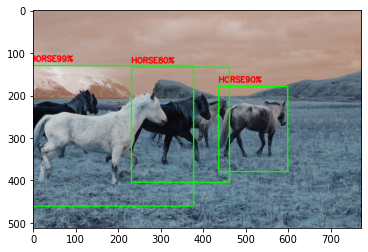

In [ ]:
# Single image obeject detection
whT = 320
conf_threshold = 0.5
nms_threshold = 0.3

img = cv2.imread('assets/horses.jpg')

blob = cv2.dnn.blobFromImage(img, 1 / 255.0, (whT, whT), swapRB=True, crop=False)
net.setInput(blob)

layernames = net.getLayerNames()

# outputnames = [(layernames[i[0] - 1]) for i in net.getUnconnectedOutLayers()]
outputnames = [(layernames[i - 1]) for i in net.getUnconnectedOutLayers()]
# print(outputnames)
outputs = net.forward(outputnames)
# print(outputs)
find_objects(outputs, img)

plt.imshow(img)


In [ ]:
# online object detection

whT = 320
conf_threshold = 0.5
nms_threshold = 0.3

# online video
cap = cv2.VideoCapture(0)

# offline demo video
# cap = cv2.VideoCapture('assets/demo_out.mp4')

while True:

    ret, img = cap.read()

    blob = cv2.dnn.blobFromImage(img, 1 / 255.0, (whT, whT), swapRB=True, crop=False)
    net.setInput(blob)

    layernames = net.getLayerNames()
    # on = [(ln[i[0] - 1]) for i in net.getUnconnectedOutLayers()]
    outputnames = [(layernames[i - 1]) for i in net.getUnconnectedOutLayers()]
    # print(outputnames)
    outputs = net.forward(outputnames)
    # print(outputs)
    find_objects(outputs, img)


    cv2.imshow('Video stream', img)
    key = cv2.waitKey(1)
    if key == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()

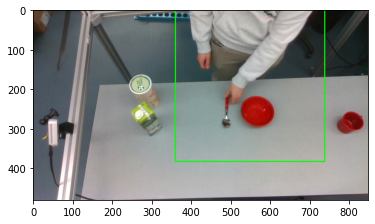

In [ ]:
# Single image obeject detection using our custom data

whT = 320
conf_threshold = 0.5
nms_threshold = 0.3

img = cv2.imread('assets/custom_pic.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

blob = cv2.dnn.blobFromImage(img, 1 / 255.0, (whT, whT), swapRB=True, crop=False)
net.setInput(blob)

layernames = net.getLayerNames()
# on = [(ln[i[0] - 1]) for i in net.getUnconnectedOutLayers()]
outputnames = [(layernames[i - 1]) for i in net.getUnconnectedOutLayers()]
# print(outputnames)
outputs = net.forward(outputnames)
# print(outputs)
find_objects(outputs, img)

plt.imshow(img)

In [ ]:
# set custom classes file
classesFile = 'assets/yolov3/custom_cfg/obj.names'
with open(classesFile,'rt') as f:
    className = f.read().rstrip('\n').split('\n')

# set custom model configuration
modelConfiguration = 'assets/yolov3/custom_cfg/yolov3_custom.cfg'

# set custom model weights
modelWeights = 'assets/yolov3/custom_cfg/yolov3_custom_last.weights'

# set YOLO-v3 network
net = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

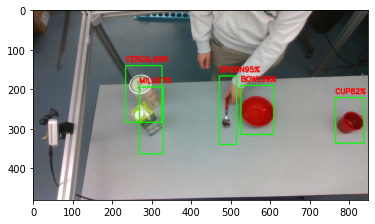

In [ ]:
# Single image obeject detection using our custom data

whT = 320
conf_threshold = 0.5
nms_threshold = 0.3

img = cv2.imread('assets/custom_pic.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

blob = cv2.dnn.blobFromImage(img, 1 / 255.0, (whT, whT), swapRB=True, crop=False)
net.setInput(blob)

layernames = net.getLayerNames()
# on = [(ln[i[0] - 1]) for i in net.getUnconnectedOutLayers()]
outputnames = [(layernames[i - 1]) for i in net.getUnconnectedOutLayers()]
# print(outputnames)
outputs = net.forward(outputnames)
# print(outputs)
find_objects(outputs, img)

plt.imshow(img)

## 1-2-2 YOLO-v3    Custom model training -  Darknet Installation


#### 1-2-2-1 Download Darknet repo
Now we start configuring the detector YOLO.
1st Step:
  Clone Darknet GitHub repository

In [ ]:
import os
os.environ['PATH'] += ':/usr/local/cuda/bin'
!rm -fr darknet
!git clone https://github.com/AlexeyAB/darknet/

Cloning into 'darknet'...
remote: Enumerating objects: 15412, done.
remote: Total 15412 (delta 0), reused 0 (delta 0), pack-reused 15412
Receiving objects: 100% (15412/15412), 14.05 MiB | 92.00 KiB/s, done.
Resolving deltas: 100% (10354/10354), done.


#### 1-2-2-2 Depedencies installation
Install gcc and g++ to make sure YOLO can run afterwards if necessary. Execute them in the terminal.

In [ ]:
# !apt install gcc-5 g++-5 -y
# !ln -s /usr/bin/gcc-5 /usr/local/cuda/bin/gcc 
# !ln -s /usr/bin/g++-5 /usr/local/cuda/bin/g++

To get the working Directory, we need to run the following code. They also installed the necessary libaries for us to run YOLO.

In [ ]:
# !apt install ffmpeg libopencv-dev libgtk-3-dev python-numpy python3-numpy libdc1394-22 libdc1394-22-dev libjpeg-dev libtiff5-dev libavcodec-dev libavformat-dev libswscale-dev libxine2-dev libgstreamer1.0-dev libgstreamer-plugins-base1.0-dev libv4l-dev libtbb-dev qtbase5-dev libfaac-dev libmp3lame-dev libopencore-amrnb-dev libopencore-amrwb-dev libtheora-dev libvorbis-dev libxvidcore-dev x264 v4l-utils unzip

········


[sudo] password for yuankai: 



Reading package lists...
Building dependency tree...
Reading state information...
libgstreamer1.0-dev is already the newest version (1.16.2-2).
libjpeg-dev is already the newest version (8c-2ubuntu8).
libmp3lame-dev is already the newest version (3.100-3).
libtheora-dev is already the newest version (1.1.1+dfsg.1-15ubuntu2).
libv4l-dev is already the newest version (1.18.0-2build1).
libvorbis-dev is already the newest version (1.3.6-2ubuntu1).
python3-numpy is already the newest version (1:1.17.4-5ubuntu3).
unzip is already the newest version (6.0-25ubuntu1).
libdc1394-22 is already the newest version (2.2.5-2.1).
libdc1394-22-dev is already the newest version (2.2.5-2.1).
libopencore-amrnb-dev is already the newest version (0.1.5-1).
libopencore-amrwb-dev is already the newest version (0.1.5-1).
libopencv-dev is already the newest version (4.2.0+dfsg-5).
libtbb-dev is already the newest version (2020.1-2).
libxine2-dev is already the newest version (1.2.9-1build5).
libxvidcore-dev is 

0

#### 1-2-2-3 Make Darknet and enable GPU for it
Now we need to go into Darknet and enable the GPU. Then finish compiling the whole Darknet.

In [ ]:
%cd darknet
!sed -i 's/GPU=0/GPU=1/g' Makefile
!sed -i 's/OPENCV=0/OPENCV=1/g' Makefile
!make

/home/yuankai/pphau/notebooks/03-Object-detection/darknet
mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
  946 |                 float rgb[3];
      |                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
 1147 |             if (iteration_ol

In file included from /usr/include/string.h:495,
                 from include/darknet.h:14,
                 from ./src/utils.h:3,
                 from ./src/utils.c:4:
In function ‘strncpy’,
    inlined from ‘copy_string’ at ./src/utils.c:531:5:
/usr/include/x86_64-linux-gnu/bits/string_fortified.h:106:10: warning: ‘__builtin_strncpy’ specified bound depends on the length of the source argument [-Wstringop-overflow=]
  106 |   return __builtin___strncpy_chk (__dest, __src, __len, __bos (__dest));
      |          ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
./src/utils.c: In function ‘copy_string’:
./src/utils.c:531:22: note: length computed here
  531 |     strncpy(copy, s, strlen(s)+1);
      |                      ^~~~~~~~~
gcc -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU 

gcc -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -c ./src/convolutional_layer.c -o obj/convolutional_layer.o
./src/convolutional_layer.c: In function ‘forward_convolutional_layer’:
./src/convolutional_layer.c:1342:32: warning: unused variable ‘t_intput_size’ [-Wunused-variable]
 1342 |                         size_t t_intput_size = binary_transpose_align_input(k, n, state.workspace, &l.t_bit_input, ldb_align, l.bit_align);
      |                                ^~~~~~~~~~~~~
gcc -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -c ./src/list.c -o obj/list.o
gcc -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-con

gcc -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -c ./src/crop_layer.c -o obj/crop_layer.o
gcc -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -c ./src/dropout_layer.c -o obj/dropout_layer.o
gcc -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -c ./src/maxpool_layer.c -o obj/maxpool_layer.o
gcc -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/loc

gcc -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -c ./src/matrix.c -o obj/matrix.o
gcc -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -c ./src/network.c -o obj/network.o
./src/network.c: In function ‘train_network_waitkey’:
./src/network.c:435:13: warning: unused variable ‘ema_period’ [-Wunused-variable]
  435 |         int ema_period = (net.max_batches - ema_start_point - 1000) * (1.0 - net.ema_alpha);
      |             ^~~~~~~~~~
./src/network.c: In function ‘resize_network’:
./src/network.c:660:42: warning: passing argument 1 of ‘cudaHostAlloc’ from incompatible pointer type [-Wincompatible-pointer-types

gcc -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -c ./src/nightmare.c -o obj/nightmare.o
gcc -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -c ./src/normalization_layer.c -o obj/normalization_layer.o
gcc -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -c ./src/avgpool_layer.c -o obj/avgpool_layer.o
gcc -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU 

gcc -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -c ./src/swag.c -o obj/swag.o
gcc -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -c ./src/shortcut_layer.c -o obj/shortcut_layer.o
./src/shortcut_layer.c: In function ‘make_shortcut_layer’:
./src/shortcut_layer.c:55:15: warning: unused variable ‘scale’ [-Wunused-variable]
   55 |         float scale = sqrt(2. / l.nweights);
      |               ^~~~~
gcc -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas

gcc -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -c ./src/gaussian_yolo_layer.c -o obj/gaussian_yolo_layer.o
./src/gaussian_yolo_layer.c: In function ‘make_gaussian_yolo_layer’:
./src/gaussian_yolo_layer.c:72:38: warning: passing argument 1 of ‘cudaHostAlloc’ from incompatible pointer type [-Wincompatible-pointer-types]
   72 |     if (cudaSuccess == cudaHostAlloc(&l.output, batch*l.outputs * sizeof(float), cudaHostRegisterMapped)) l.output_pinned = 1;
      |                                      ^~~~~~~~~
      |                                      |
      |                                      float **
In file included from /usr/local/cuda/include/cuda_runtime.h:96,
                 from include/darknet.h:41,
                 from ./src/gaussian_yolo_layer.h:5,
                 from ./src/gaus

./src/activation_kernels.cu(263): warning: variable "MISH_THRESHOLD" was declared but never referenced

./src/activation_kernels.cu(263): warning: variable "MISH_THRESHOLD" was declared but never referenced

./src/activation_kernels.cu(263): warning: variable "MISH_THRESHOLD" was declared but never referenced

./src/activation_kernels.cu(263): warning: variable "MISH_THRESHOLD" was declared but never referenced

nvcc -gencode arch=compute_35,code=sm_35 -gencode arch=compute_50,code=[sm_50,compute_50] -gencode arch=compute_52,code=[sm_52,compute_52] -gencode arch=compute_61,code=[sm_61,compute_61] -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ --compiler-options "-Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU" -c ./src/im2col_kernels.cu -o obj/im2col_kernels.o
nvcc warning : The 'compute_35', 'compute_37', 'compute_50', 'sm_35', 'sm_37' and 'sm_

nvcc -gencode arch=compute_35,code=sm_35 -gencode arch=compute_50,code=[sm_50,compute_50] -gencode arch=compute_52,code=[sm_52,compute_52] -gencode arch=compute_61,code=[sm_61,compute_61] -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ --compiler-options "-Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU" -c ./src/network_kernels.cu -o obj/network_kernels.o
nvcc warning : The 'compute_35', 'compute_37', 'compute_50', 'sm_35', 'sm_37' and 'sm_50' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).
./src/network_kernels.cu(379): warning: variable "l" was declared but never referenced

./src/network_kernels.cu(379): warning: variable "l" was declared but never referenced

./src/network_kernels.cu(379): warning: variable "l" was declared but never referenced

./src/network_kernels.

Make darknet executable, and download yolov3 pretrained weights

In [ ]:
!chmod a+x ./darknet

# You can also download yolov3 and yolov4 weights if you need them. We provide yolov3 pretrained weights in 'assets' folder
# !wget https://pjreddie.com/media/files/yolov3.weights
# !wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights

--2022-03-29 13:42:08--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights        0%[                    ]   2,12M  31,6KB/s    eta 66m 16s^C


In [ ]:
# check the current path
!pwd

/home/yuankai/pphau/notebooks/03-Object-detection/darknet


Now we can choose a picture that you want to do object detection in the path **"data/xx.jpg"**. And the result will be saved as predictions.jpg

In [ ]:
!./darknet detector test cfg/coco.data cfg/yolov3.cfg ../yolov3.weights -ext_output data/person.jpg

 CUDA-version: 11040 (11040), GPU count: 1  
 OpenCV version: 4.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Quadro RTX 3000 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 104 x 

Done! Loaded 107 layers from weights-file 
 Detection layer: 82 - type = 28 
 Detection layer: 94 - type = 28 
 Detection layer: 106 - type = 28 
data/person.jpg: Predicted in 852.096000 milli-seconds.
dog: 99%	(left_x:   59   top_y:  262   width:  147   height:   89)
person: 100%	(left_x:  190   top_y:   95   width:   86   height:  284)
horse: 100%	(left_x:  394   top_y:  137   width:  215   height:  206)


- **If you got the output picture, congratulations! Darknet has been successfully installed.**
- And now we ned to use Darknet for custom training!

Firstly, you need to export your annotation from **CVAT**. The link: https://cvat.org/

- Make sure your export data as YOLO form. 
- ### An example folder has been putted in the 'assets' folder.

## 1-2-2 YOLO-v3    Custom model training - Training Configuration


To finish the custom model training, you need to build a **"custom_data"** folder and put your annotated dataset (from **CVAT**) in the "custom_data" folder. Do not forget to change the corresponding path inside of 'obj.data' and 'train.txt'

Copy the pretraned weights **darknet53.conv.74** to the cutom_train folder.

    
Create file **yolov3_custom.cfg** with the same content as in **yolov3.cfg** and:
    
    1. Change line batch to batch=64
    2. Change line subdivisions to subdivisions=16 (Could be out of memory, try 32 or 64 then)
    3. Change line max_batches to (classes*2000, but not less than number of training images and not less than 6000), f.e. max_batches=6000 if you train for 3 classes
    4. Change line steps to 80% and 90% of max_batches, f.e. steps=4800,5400
    5. Set network size width=416 height=416 or any value multiple of 32: 
         width=416 
         height=416
    6. Change [filters=255] to filters=(classes + 5)x3 in the 3 [convolutional] before each [yolo] layer, keep in mind that it only has to be the last [convolutional] before each of the [yolo] layers. And you also need to change the classes in [yolo] to the class number you have.
    7. Use the commend line below:
    !./darknet detector train custom_data/obj.data custom_data/yolov3_custom.cfg custom_data/darknet53.conv.74 -dont_show
    
Reference: https://github.com/AlexeyAB/darknet 

### Loss of custom training

<figure style="text-alin:center">
<img src="assets/yolov3/custom_data/chart_yolov3_custom.png" width="480" height="320"/>
<figcaption >  </figcaption>
</figure>

In [ ]:
# Use this code in notebook, if it takes too lone, try to run below code in terminal
# !./darknet detector train custom_data/obj.data custom_data/yolov3_custom.cfg custom_data/darknet53.conv.74

# Use this code in terminal
#./darknet detector train custom_data/obj.data custom_data/yolov3_custom.cfg custom_data/darknet53.conv.74

**After custom training, you can get retrained weights, config files. You can use them for your custom datasets.**

Darknet also provide **yolov4**, you can test it with the code below:

In [ ]:
!./darknet detector test cfg/coco.data cfg/yolov4.cfg yolov4.weights -thresh 0.25 

 CUDA-version: 11010 (11020), GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 8, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   3 route  1 		                           ->  304 x 304 x  64 
   4 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   5 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   6 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 304 x 304 x  64 0.006 BF
   8 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 B

In the next, we will introduce Mask RCNN.

# 2-1 Mask R-CNN for instance segmentation

# 2-1-1 What is Mask R-CNN

Mask R-CNN is a state-of-the-art deep learning model for instance segmentation. It is built on top of Faster R-CNN and a region-based convolutional neural network.   Instead of predicting the bounding boxes of objects in an image or frame, Mask R-CNN predicts the semantic labels for every pixel of the image or frame.

Source: Faster R-CNN https://arxiv.org/pdf/1506.01497.pdf

**What is the different between semantic segmentation and instance segmentation?**

Unlike the image segmentation method, Mask R-CNN is an instance segmentation method. It can predict not only the category for each pixel, but also their object instances.


<figure style="text-alin:center">
<img src="assets/image_segmentation_instance.PNG" width="640" height="480"/>
<figcaption >  </figcaption>
</figure>

Source: V. Varatharasan, H. Shin, A. Tsourdos and N. Colosimo, "Improving Learning Effectiveness For Object Detection and Classification in Cluttered Backgrounds," 2019 Workshop on Research, Education and Development of Unmanned Aerial Systems (RED UAS), 2019, pp. 78-85, doi: 10.1109/REDUAS47371.2019.8999695.





**What is R-CNN?**

R-CNN first takes an RGB image as input and generates around 2000 bottom-up region proposals. These regions roughly describe the locations of the objects. Afterward, a convolutional neural network is used to compute features for each proposal. Finally, a class-specific linear SVMs is used for classifying each region.

<figure style="text-alin:center">
<img src="assets/rcnn.PNG" width="640" height="480"/>
<figcaption >  </figcaption>
</figure>


Source: R. Girshick, J. Donahue, T. Darrell and J. Malik, "Rich Feature Hierarchies for Accurate Object Detection and Semantic Segmentation," 2014 IEEE Conference on Computer Vision and Pattern Recognition, 2014, pp. 580-587, doi: 10.1109/CVPR.2014.81.


**How Mask R-CNN works?**

Mask R-CNN is built on top of Faster R-CNN. It has 2 stages. Similar to R-CNN, the first stage uses a region proposal network to extract the region of interesting, Then in the second stage, Mask R-CNN is using two-branch to predict the outputs. Its output including bounding box, class label and an object mask. The bounding box and class label are similar to YOLO, the additional object mask shows the region of interest in pixel level.


<figure style="text-alin:center">
<img src="assets/mask_rcnn_1.PNG" width="640" height="480"/>
<figcaption >  </figcaption>
</figure>

Source: He, Kaiming, et al. "Mask r-cnn." Proceedings of the IEEE international conference on computer vision. 2017.



## 2-1-2 Detectron2 for Mask R-CNN

In [ ]:
# Install detectron2 dependencies

!pip install torch==1.10.0+cu111 torchvision==0.11.1+cu111 -f https://download.pytorch.org/whl/torch_stable.html
!pip install git+https://github.com/facebookresearch/fvcore.git

Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Using cached https://download.pytorch.org/whl/cu111/torch-1.10.0%2Bcu111-cp38-cp38-linux_x86_64.whl (2137.6 MB)
  Using cached https://download.pytorch.org/whl/cu111/torchvision-0.11.1%2Bcu111-cp38-cp38-linux_x86_64.whl (24.5 MB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-5xme6at7
  Running command git clone -q https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-5xme6at7
  Using cached yacs-0.1.8-py3-none-any.whl (14 kB)
  Using cached iopath-0.1.9-py3-none-any.whl (27 kB)
  Using cached portalocker-2.4.0

In [ ]:
# Download detectron2 from facebook research

!git clone https://github.com/facebookresearch/detectron2 detectron2_repo

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 13924, done.
remote: Total 13924 (delta 0), reused 0 (delta 0), pack-reused 13924
Receiving objects: 100% (13924/13924), 5.71 MiB | 10.87 MiB/s, done.
Resolving deltas: 100% (10065/10065), done.


In [ ]:
# Install detectron2

!pip install -e detectron2_repo
#!pip install detectron2
!pip install 'git+https://github.com/facebookresearch/detectron2.git'
!pip install pycocotools

Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///home/yuankai/pphau/notebooks/03-Object-detection/detectron2_repo
  Using cached pycocotools-2.0.4-cp38-cp38-linux_x86_64.whl
  Using cached omegaconf-2.1.1-py3-none-any.whl (74 kB)
  Using cached hydra_core-1.1.1-py3-none-any.whl (145 kB)
  Using cached black-21.4b2-py3-none-any.whl (130 kB)
  Using cached scipy-1.8.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (41.6 MB)
  Using cached pathspec-0.9.0-py2.py3-none-any.whl (31 kB)
  Using cached regex-2022.3.15-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (764 kB)
  Using cached toml-0.10.2-py2.py3-none-any.whl (16 kB)
     |████████████████████████████████| 96 kB 3.5 MB/s eta 0:00:011
  Using cached mypy_extensions-0.4.3-py2.py3-none-any.whl (4.5 kB)
  Using cached antlr4_python3_runtime-4.8-py3-none-any.whl
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
  Attempting uninstall: google-auth-oaut

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.


In [ ]:
!pwd

/home/yuankai/pphau/notebooks/03-Object-detection


In [ ]:
from functools import partial
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import torch, torchvision
# torch.__version__
import numpy as np
import cv2
from detectron2.engine import DefaultPredictor
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
import pycocotools.mask as coco_mask
from detectron2.config import get_cfg
import os

In [ ]:
# Set expected object classes
OBJ_CLASSES = {
    0: '00_person',
    1: '01_checkerboard',
    2: '02_spoon',
    3: '03_milk',
    4: '04_bowl',
    5: '05_oats',

}

INV_OBJ_CATEGORIES = {v: k for k,v in OBJ_CLASSES.items()}
print(INV_OBJ_CATEGORIES)

{'00_person': 0, '01_checkerboard': 1, '02_spoon': 2, '03_milk': 3, '04_bowl': 4, '05_oats': 5}


In [ ]:
# Create object masks

def create_sub_masks(mask_image, width, height):
    # Initialize a dictionary of sub-masks indexed by RGB colors
    sub_masks = {}

    # 'r': 1.0, 'g': 0.9215686321258545, 'b': 0.01568627543747425, 'a': 1.0

    # sub_masks[1] = mask_image[:,:,1.0, 0.9215686321258545, 0.01568627543747425]
    # sub_masks[1] = mask_image[:,:]
    img1 = np.zeros((width, height), dtype=np.uint8)
    img2 = np.zeros((width, height), dtype=np.uint8)
    img3 = np.zeros((width, height), dtype=np.uint8)
    img4 = np.zeros((width, height), dtype=np.uint8)
    img5 = np.zeros((width, height), dtype=np.uint8)
    img6 = np.zeros((width, height), dtype=np.uint8)

    for x in range(width):
        for y in range(height):
            pixel = mask_image[x, y]
            if pixel[2] == 0 and pixel[1] == (int)(128) and pixel[0] == (int)(128):
                img1[x, y] = 255
            elif pixel[2] == (int)(128) and pixel[1] == (int)(0) and pixel[0] == (int)(0):
                img2[x, y] = 255
            elif pixel[2] == (int)(128) and pixel[1] == (int)(128) and pixel[0] == (int)(0):
                img3[x, y] = 255
            elif pixel[2] == (int)(0) and pixel[1] == (int)(128) and pixel[0] == (int)(0):
                img4[x, y] = 255
            elif pixel[2] == (int)(0) and pixel[1] == (int)(0) and pixel[0] == (int)(128):
                img5[x, y] = 255
            elif pixel[2] == (int)(128) and pixel[1] == (int)(0) and pixel[0] == (int)(128):
                img6[x, y] = 255
            # print(pixel)

    sub_masks[0] = img1  # person
    sub_masks[1] = img2  # chekerboard
    sub_masks[2] = img3  # spoon
    sub_masks[3] = img4  # milk
    sub_masks[4] = img5  # bowl
    sub_masks[5] = img6  # oats
    return sub_masks

In [ ]:
# dex-ycb hand segmentation function

def dexycb_hand_seg_func_mivos(num_samples=-1, ignore_background=False, dir='assets/mask_rcnn/content/mivos', step_size=50):
    data_dir = dir
    subjects = [f for f in os.listdir(data_dir) if 'subject' in f]
    print(subjects)
    lst = []

    prefix = f"{data_dir}"
    length = num_samples
    print(length)
    for i in range(0, length, 1):
        color_file = f"{prefix}/images/color%04d.jpg" % (i * step_size)
        seg_mask = f"{prefix}/mask/%05d.png" % i
        print(color_file)
        print(seg_mask)

        assert os.path.exists(color_file)
        assert os.path.exists(seg_mask)
        seg_img = cv2.imread(seg_mask)
        height, width, channels = seg_img.shape

        a = create_sub_masks(seg_img, height, width)
        annotations = []

        for j in range(len(a)):
            rel_mask = coco_mask.encode(np.asfortranarray(a[j]))
            rows, cols = np.where(a[j])
            category_label, category_id = get_category2(j)
            print(rows.any())

            if rows.any():
                print("Entered Annotator")
                annotation = {
                    'bbox': [min(cols), min(rows), max(cols), max(rows)],
                    'bbox_mode': BoxMode.XYXY_ABS,
                    'category_id': category_id,
                    'segmentation': rel_mask
                }

                print(annotation)

                annotations.append(annotation)

        dct = {
            'file_name': color_file,
            'height': height,
            'width': width,
            'image_id': i,
            'annotations': annotations,
        }

        lst.append(dct)
        if len(lst) == length:
            return lst


In [ ]:
# Get object class

def get_category2(id):
    
    k = OBJ_CLASSES[id]

    return k, INV_OBJ_CATEGORIES[k]

In [ ]:
# Build Detectron2Wrapper

class Detectron2Wrapper:

    def __init__(self, cfg_path="assets/mask_rcnn/cfg_mivos.yaml"):
        cfg2 = get_cfg()
        cfg2.merge_from_file(cfg_path)
        # value is the threshold used to filter out low-scored bounding boxes predicted by the 
        # Fast R-CNN component of the model during inference/test time.
        cfg2.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set the testing threshold for this model
        cfg2.DATASETS.TEST = ("Mivos",)
        self.predictor = DefaultPredictor(cfg2)
        self.gen_meta()
        # self.predictor = predictor

    def gen_meta(self):
        DatasetCatalog.register("Mivos", partial(dexycb_hand_seg_func_mivos,
                                                        num_samples=2,
                                                        ignore_background=True,
                                                        dir='assets/mask_rcnn/content/mivos',
                                                        step_size=50))
        dataset = DatasetCatalog.get("Mivos")
        self.meta = MetadataCatalog.get("Mivos")
        num_categories = len(OBJ_CLASSES)
        self.meta.num_categories = num_categories
        self.meta.thing_classes = [OBJ_CLASSES[i] for i in range(num_categories)]

    def process(self, img_bgr):
        outputs = self.predictor(img_bgr)
        mask = outputs["instances"].get("pred_masks").to("cpu")
        classes = outputs["instances"].get("pred_classes").to("cpu")
        mask = mask.numpy()
        classes = classes.numpy()
        return mask, classes

In [ ]:
# Initialize Detectron2Wrapper as 'det'

from matplotlib import pyplot as plt


det = Detectron2Wrapper()

# img_bgr = cv2.imread("bag_1/camera_135122071615/color%04d.jpg"%j)


[]
2
assets/mask_rcnn/content/mivos/images/color0000.jpg
assets/mask_rcnn/content/mivos/mask/00000.png
True
Entered Annotator
{'bbox': [397, 0, 741, 182], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0, 'segmentation': {'size': [480, 848], 'counts': b'kSj56V>n0_Of0Ae0[O8H4L4L3M2N2N2N2N2N5K9G4L3M3M3M3M3M2N2N2N2N1O2N1O1O1O1O1O1O1O001O1O001O00001O001O3UFRK^9Z5N1O1O1O001O00000000000000000000000000000000000000000000000000000000O1000000000000O10000000000O1000000O100O1O1O100N2N2O1O1001O2N2N000000001O1O00001O000000001O000000000000O1000000000000000000O1000000000000O1000000O100O100O100O1O100O100O100O100O10000O10000O1000000O10000O1000000O1000000O1000000O100O100O10000O100O100O100O1O100O100O1O1O100N2O10000001cEfKR:f4N1O1O1O001O00cNUF`LOo0k9[2fFbMZ9Z2iFhMV9U2lFlMT9Q2oFoMQ9o1QGQNo8l1RGVNn8g1RG\\Nn8a1TG`Nl8^1UGcNk8\\1TGfNl8X1UGiNk8U1UGlNl8S1TGnNl8Q1TGoNm8o0TGQOm8m0SGTOn8k0RGVOn8i0QGXOP9g0oFZOR9e0bFG_97`FL`94]FNd92XF2h9MWF4j9KUF6l9LoE6R:\\20O1O100O1N2O1O1N2O1N2O1N2O1O1O1O1N2O1N2N2N2N2O1O1O1O1O1O1

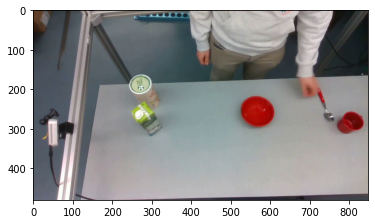

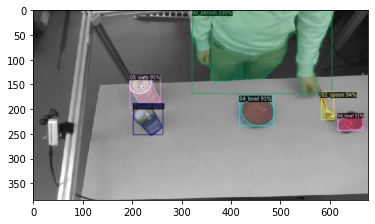

In [ ]:
# Imread image and process single image using detectron2

from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode

j = 100
img_bgr = cv2.imread("assets/mask_rcnn/test_images/frame_%06d.PNG"%j)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
result = det.predictor(img_rgb)


# print(result)

v = Visualizer(img_rgb[:, :, ::-1],
                   metadata=det.meta, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )


v = v.draw_instance_predictions(result["instances"].to("cpu"))

plt.figure()

plt.imshow(v.get_image()[:, :, ::-1])


In [ ]:
# if error happened, check the version of your torch and torchvision.
print(torch.__version__)
print(torchvision.__version__)

1.10.0+cu111
0.11.1+cu111


In [ ]:
# Use Detectron2 for Video input, we ues the demo video which you can find in the 'assets' folder
import cv2

cap = cv2.VideoCapture('assets/demo_out.mp4')
# cap = cv2.VideoCapture(0)

while True:
    
    ret, img = cap.read()
    
    
    result = det.predictor(img)
    
    # v = Visualizer(img, 
    v = Visualizer(img[:, :, ::-1],              
                   metadata=det.meta, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    
    v = v.draw_instance_predictions(result["instances"].to("cpu"))
    
    # cv2.imshow('Video stream', v.get_image()[:, :, ::-1])
    cv2.imshow('Video stream', v.get_image())
    
    key = cv2.waitKey(1)
    if key == ord("q"):
        break
        
cap.release()
cv2.destroyAllWindows()


## 2-1-3  Detectron2 custom training for Mask R-CNN using annotation from MiVOS








###  Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on you custom dataset.


In [ ]:
!pwd

/home/yuankai/pphau/notebooks/03-Object-detection


In [ ]:
# Configure the Trainer for Detectron2

from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file("detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("Mivos",)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.DEVICE= 'cuda:0'   #for GPU, otherwise 'cpu'


In [ ]:
# Initialize the model weights

cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl" 

In [ ]:
# Initialize meta and set num of classes for Mask R-CNN output

OBJ_CLASSES = {
    0: '00_person',
    1: '01_checkerboard',
    2: '02_spoon',
    3: '03_milk',
    4: '04_bowl',
    5: '05_oats',

}
num_categories = len(OBJ_CLASSES)

meta = MetadataCatalog.get("Mivos")

meta.num_categories = num_categories

meta.thing_classes = [OBJ_CLASSES[i] for i in range(num_categories)]

# print(dataset)

# cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_categories

In [ ]:
# Initializ Trainer
# If you run the code, maybe you get warning because of the last layer demension is different from loading weights

cfg.MODEL.DEVICE= 'cuda:0'
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.02
cfg.SOLVER.MAX_ITER = 300 # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_categories
cfg.INPUT.MASK_FORMAT = 'bitmask'
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)


Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, b

[03/30 15:09:09 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[]
2
assets/mask_rcnn/content/mivos/images/color0000.jpg
assets/mask_rcnn/content/mivos/mask/00000.png
True
Entered Annotator
{'bbox': [397, 0, 741, 182], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 0, 'segmentation': {'size': [480, 848], 'counts': b'kSj56V>n0_Of0Ae0[O8H4L4L3M2N2N2N2N2N5K9G4L3M3M3M3M3M2N2N2N2N1O2N1O1O1O1O1O1O1O001O1O001O00001O001O3UFRK^9Z5N1O1O1O001O00000000000000000000000000000000000000000000000000000000O1000000000000O10000000000O1000000O100O1O1O100N2N2O1O1001O2N2N000000001O1O00001O000000001O000000000000O1000000000000000000O1000000000000O1000000O100O100O100O1O100O100O100O100O10000O10000O1000000O10000O1000000O1000000O1000000O100O100O10000O100O100O100O1O100O100O1O1O100N2O10000001cEfKR:f4N1O1O1O001O00cNUF`LOo0k9[2fFbMZ9Z2iFhMV9U2lFlMT9Q2oFoMQ9o1QGQNo8l1RGVNn8g1RG\\Nn8a1TG`Nl8^1UGcNk8\\1TGfNl8X1UGiNk8U1UGlNl8S1TGnNl8Q1TGoNm8o0TGQOm8m0SGTOn8k0RGVOn8i0QGXOP9g0oFZOR9e0bFG_97`FL`94]FNd92XF2h9MWF4j9KUF6l9LoE6R:\\20O1O100O1N2O1O1N2O1N2O1N2O1O1O1O1N2O1N2N2N2N2O1O1O1O1O1O1

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (7, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (7,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (24, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (24,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (6, 256, 1, 1) 

In [ ]:
# Start Custom training for Mask R-CNN
trainer.train()

[03/30 15:09:21 d2.engine.train_loop]: Starting training from iteration 0
[03/30 15:09:32 d2.utils.events]:  eta: 0:02:27  iter: 19  total_loss: 2.476  loss_cls: 0.925  loss_box_reg: 0.9527  loss_mask: 0.6181  loss_rpn_cls: 0.00469  loss_rpn_loc: 0.01311  time: 0.5324  data_time: 0.0146  lr: 0.0012854  max_mem: 3174M
[03/30 15:09:43 d2.utils.events]:  eta: 0:02:26  iter: 39  total_loss: 1.333  loss_cls: 0.3524  loss_box_reg: 0.7765  loss_mask: 0.1974  loss_rpn_cls: 0.001014  loss_rpn_loc: 0.01012  time: 0.5447  data_time: 0.0041  lr: 0.0026174  max_mem: 3174M
[03/30 15:09:53 d2.utils.events]:  eta: 0:02:13  iter: 59  total_loss: 0.4928  loss_cls: 0.1014  loss_box_reg: 0.3067  loss_mask: 0.06334  loss_rpn_cls: 0.0002192  loss_rpn_loc: 0.01313  time: 0.5395  data_time: 0.0040  lr: 0.0039494  max_mem: 3174M
[03/30 15:10:04 d2.utils.events]:  eta: 0:02:03  iter: 79  total_loss: 0.3986  loss_cls: 0.08187  loss_box_reg: 0.2624  loss_mask: 0.04453  loss_rpn_cls: 0.0003904  loss_rpn_loc: 0.012

**Now you can use the fine-tuned weights for Mask R-CNN inference**  

# Homework


- Task 1 YOLO 2 Students + 3D visualizer
- Task 2 Mask R-CNN 2 Students + 3D visualizer

## Task 1 (2 Students):
### 1.1 Fine-tune YOLOv3/Detectron2 using your custom dataset.
Tips: 
- Do not need to use all of the images from video. You can sample images with different scenarios.

### 1.2 Apply forground background segmentation using K-means (color, x-y-z (3D position of pointcoulds)) after processing one image from yolov3.

Tips: 
- You can use K-Means from sklearn.cluster. And consider you have object and background in a bounding box.
- For x-y-z, you can use the reconstruction method from Tutorial 1.

In [ ]:
from sklearn.cluster import KMeans



### 1.3 Convert the clustering results into a segmentation image.

Tips: 
- You can use the overlay function below:

In [ ]:
# First we need a overlay function to overlay the mask
from scipy.ndimage import binary_dilation

def overlay_function(image, mask, alpha=0.5):
    '''
    image: input rgb image
    mask:  an image with same dimension as image, but class label in pixel-level 
    '''
    
    color_map = [
        [0, 0, 0],
        [255, 255, 50],
        [255, 50, 50],
        [50, 255, 50],
        [50, 50, 255],
        [255, 50, 255],
        [50, 255, 255]
        
    ]

    color_map_np = np.array(color_map)

    """ Overlay segmentation on top of RGB image """
    im_overlay = image.copy()

    colored_mask = color_map_np[mask]
    foreground = image * alpha + (1 - alpha) * colored_mask
    binary_mask = (mask > 0)
    # Compose image
    im_overlay[binary_mask] = foreground[binary_mask]
    countours = binary_dilation(binary_mask) ^ binary_mask
    im_overlay[countours, :] = 0
    return im_overlay.astype(image.dtype)

### 1.4 Integrate the function  into the 3D visualizer.

## Task 2 Mask R-CNN (2 Students):
### 2.1 Use detectron2 to process the same image and generate the semantic pointcloud.

### 2.2 Compare both segmentation results with ground truth from MiVOS (pixel-wise acc).
- link

### 2.3 Try different smoothing functions on depth and check the result visually.

Tips: 
- Realsense default filter
- You can use different blurring filter in Opencv. # Gaussian Blurring, Median Blurring, Bilateral Filtering

### 2.4 Integrate the function  into the 3D visualizer.